<a href="https://colab.research.google.com/github/HeidiHufford/uplimit-synthetic-data/blob/main/Project_1_Generating_Data_For_Supervised_Fine_Tuning_(SFT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Generating Data For Supervised Fine-Tuning (SFT)


First, install the required dependencies.

In [ ]:
!uv pip install "distilabel[hf-inference-endpoints,openai,ollama] @ git+https://github.com/argilla-io/distilabel.git@develop" "model2vec" "semhash" "accelerate" "datasets<4.0.0" "transformers>=4.54.0" -U -q

⚠️ Warning

Google Colab doesn't prompt you to restart the environment in order to use
numpy smaller than 2.0.0 after a downgrade. You need to do that manually. So go to the dropdown next to "Run all" and restart the session. Similarly, if you experience a notebook being stuck, try to go for a hard reset by disconecting and deleting the runtime.

Next, we can log in to the Hugging Face Hub and configure our token through the login method.

In [ ]:
from huggingface_hub import login

login()

Or use the Google Colab secrets integrations.


In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(token=(userdata.get('HF_TOKEN')))

## 1. Generate a dataset for instruction tuning

### Basic dataset

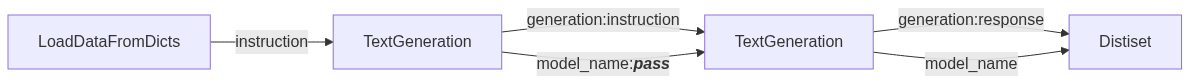

In [ ]:
from distilabel.models.llms import TransformersLLM
from distilabel.pipeline import Pipeline
from distilabel.steps import LoadDataFromDicts
from distilabel.steps.tasks import TextGeneration

with Pipeline() as pipeline:
    data = LoadDataFromDicts(
        data=[{"instruction": "Generate a question about synthetic data."}]
    )
    llm=TransformersLLM(
        model="HuggingFaceTB/SmolLM2-360M-Instruct",
        device_map="auto",
        torch_dtype="bfloat16"
    )
    gen_a = TextGeneration(
        llm=llm,
        output_mappings={"generation": "instruction"}
    )
    gen_b = TextGeneration(
        llm=llm,
        output_mappings={"generation": "response"}
    )
    data >> gen_a >> gen_b

pipeline

In [ ]:
username = "uplimit"
distiset = pipeline.run(use_cache=False)
distiset.push_to_hub(
    f"{username}/uplimit-synthetic-data-week-1-basic", include_script=True
)

### With seed data


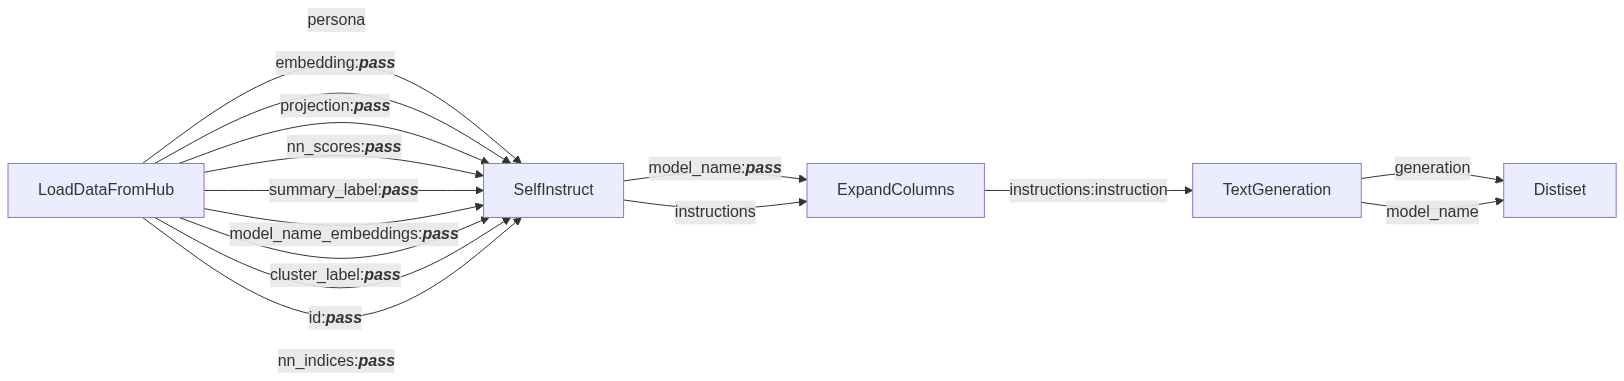

In [ ]:
from distilabel.models.llms.huggingface import TransformersLLM
from distilabel.pipeline import Pipeline
from distilabel.steps import LoadDataFromHub, ExpandColumns
from distilabel.steps.tasks import SelfInstruct, TextGeneration

with Pipeline() as pipeline:
    data = LoadDataFromHub(
        repo_id="dvilasuero/finepersonas-v0.1-tiny",
        num_examples=1
    )
    llm = TransformersLLM(
        model="HuggingFaceTB/SmolLM2-360M-Instruct",
        device_map="auto",
        torch_dtype="bfloat16"
    )
    gen_a = SelfInstruct(llm=llm, input_mappings={"input": "persona"})
    expand_columns = ExpandColumns(
        columns=["instructions"],
        output_mappings={"instructions": "instruction"}
    )
    gen_b = TextGeneration(llm=llm)
    data >> gen_a >> expand_columns >> gen_b

pipeline

In [ ]:
username = "uplimit"
distiset = pipeline.run(use_cache=False)
distiset.push_to_hub(
    f"{username}/uplimit-synthetic-data-week-1-with-seed", include_script=True
)

### With instruction evolution and seed data


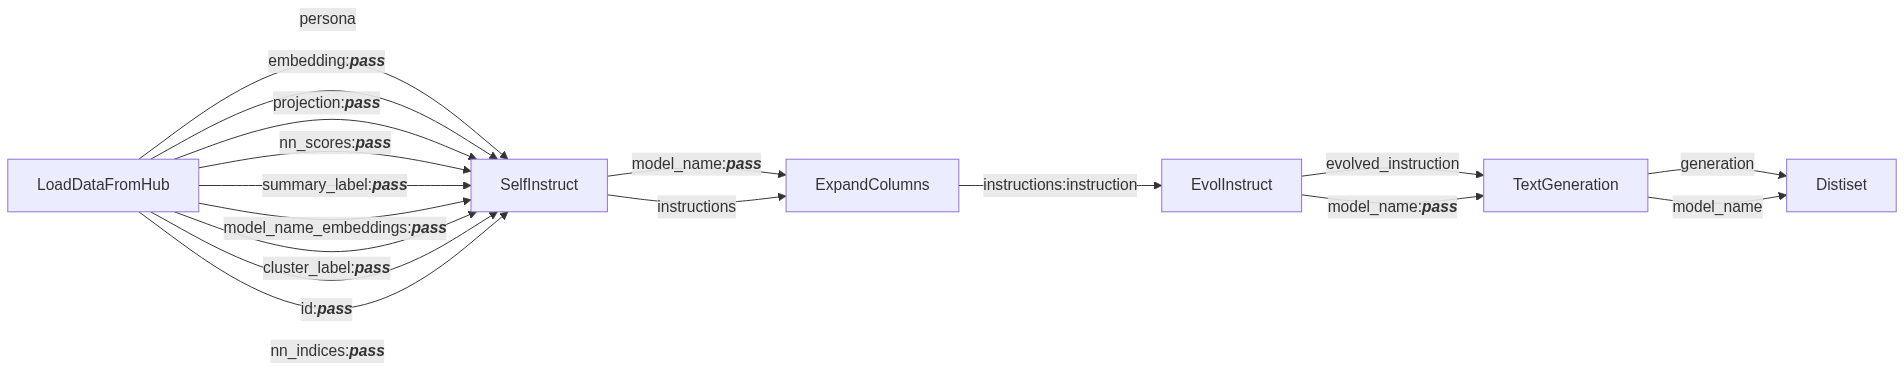

In [ ]:
from distilabel.models.llms.huggingface import TransformersLLM
from distilabel.pipeline import Pipeline
from distilabel.steps import LoadDataFromHub, ExpandColumns
from distilabel.steps.tasks import EvolInstruct, SelfInstruct, TextGeneration

with Pipeline() as pipeline:
    data = LoadDataFromHub(
        repo_id="dvilasuero/finepersonas-v0.1-tiny",
        num_examples=1
    )
    llm = TransformersLLM(
        model="HuggingFaceTB/SmolLM2-360M-Instruct",
        device_map="auto",
        torch_dtype="bfloat16"
    )
    gen_a = SelfInstruct(llm=llm, input_mappings={"input": "persona"})
    expand_columns = ExpandColumns(
        columns=["instructions"],
        output_mappings={"instructions": "instruction"}
    )
    gen_b = EvolInstruct(
        llm=llm, num_evolutions=1, input_mappings={"instruction": "instructions"}
    )
    gen_c = TextGeneration(
        llm=llm, input_mappings={"instruction": "evolved_instruction"}
    )
    data >> gen_a >> expand_columns >> gen_b >> gen_c

pipeline

In [ ]:
username = "uplimit"
distiset = pipeline.run(use_cache=False)
distiset.push_to_hub(
    f"{username}/uplimit-synthetic-data-week-1-with-evol",
    include_script=True,
)

### With multi-turn conversations

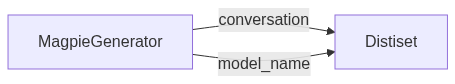

In [ ]:
from distilabel.models.llms.huggingface import TransformersLLM
from distilabel.pipeline import Pipeline
from distilabel.steps.tasks import MagpieGenerator

with Pipeline() as pipeline:
    llm = TransformersLLM(
        model="HuggingFaceTB/SmolLM2-360M-Instruct",
        device_map="auto",
        torch_dtype="bfloat16",
        tokenizer="HuggingFaceTB/SmolLM2-360M-Instruct",
        magpie_pre_query_template="qwen2",
        use_magpie_template=True,
    )
    gen_a = MagpieGenerator(llm=llm, n_turns=2, num_rows=1)

pipeline

In [ ]:
username = "uplimit"
distiset = pipeline.run(use_cache=False)
distiset.push_to_hub(
    f"{username}/uplimit-synthetic-data-week-1-with-multi-turn",
    include_script=True,
)


## 2. Explore and evaluate the generated data

“Look at  your data!” is a phrase that often comes by a lot during the various phases of AI development. It is important to be able to understand where your data performs well and where it might be improved. You can consider feature engineering through basic heuristics or through more advanced methods like entropy, embeddings or classification models.

There are many interesting resources to do data exploration and cleaning with but we will name a couple to get you started.

The Dataset Tools organisation on Hugging Face hold collections of tools and models to explore data or do feature engineering, like a domain classifier, a really fast embedder, and a toxicity classifier.

There is an integration with Nomic AI that allows you to Explore, Curate and Vector Search Any Hugging Face Dataset with Nomic Atlas

Text Descriptives is a Python library for calculating a large variety of metrics from text.

Explore and potentially filter your generated dataset. Report on this analysis within your published dataset by updating the dataset and by adding scripts, written text, photos or videos.


Let's first use semhash to deduplicate records based on semantic similarity.

In [ ]:
from datasets import load_dataset
from semhash import SemHash
from transformers import pipeline


ds = load_dataset(path="argilla/distilabel-intel-orca-dpo-pairs", split="train")

semhash = SemHash.from_records(records=ds["input"])

# Deduplicate the texts
deduplicated_texts = semhash.self_deduplicate(threshold=0.8).deduplicated
print(f"Original dataset: {len(ds)}. Filtered dataset: {len(deduplicated_texts)}. Percentage left: {len(deduplicated_texts)/len(ds)}")

Now, we can add a score to each of the text based on their educational value.

In [ ]:
from transformers import pipeline

pipe = pipeline(
    task="text-classification",
    model="HuggingFaceFW/fineweb-edu-classifier"
)

quality_predictions = pipe(deduplicated_texts, truncation=True, verbose=True)

Finally, we can filter based on a minimum score and certain percentage of records.

In [ ]:
import pandas as pd

quality_scores = [i["score"] for i in quality_predictions]

df = pd.DataFrame.from_dict(
    {
        "text": deduplicated_texts,
        "quality": quality_scores
    }
)
p_to_keep = 0.8
min_score = 0.8
df.sort_values(by="quality", ascending=False, inplace=True)
df = df.head(int(len(df)*p_to_keep))
df = df[df["quality"] > min_score]
print(f"Original dataset: {len(ds)}. Filtered dataset: {len(df)}. Percentage left: {len(df)/len(ds)}")

## 3. Publish the dataset on Hugging Face

Publish the dataset on the Hugging Face Hub. Make sure you update the ModelCard with all relevant information. Additionally, link the exploratory data analysis and preferably also add an analysis script.

In [ ]:
from datasets import Dataset

ds = Dataset.from_pandas(df, preserve_index=False)
ds = ds.push_to_hub("uplimit/uplimit-synthetic-data-week-1-filtered")

Now, we can go to our dataset page and update the ModelCard with all relevant information. Additionally, we can add an analysis script.